In [1]:
from __future__ import print_function, division
%matplotlib inline
import mdtraj as md
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import re

In [4]:
import seaborn

In [5]:
%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [6]:
%watermark -d -t -v -m -p numpy,scipy,pandas,mdtraj -g

07/09/2015 15:45:57 

CPython 2.7.10
IPython 3.2.0

numpy 1.9.2
scipy 0.15.1
pandas 0.16.2
mdtraj 1.4.2

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.11.0-26-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit
Git hash   : 80a11892103e08f9d1ad3e39ef48983f244bbb9e


### Defining the radial distribution function

When this project started, I had to define the radial distribution function. It is not really necessary nowadays as the function "compute_rdf" is available since february 2015.

In [7]:
def smooth(x,window_len=11,window='hanning'):
    """
    The code comes from: http://wiki.scipy.org/Cookbook/SignalSmooth
    
    smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
        flat window will produce a moving average smoothing.
       
    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    """
    
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
    
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len)
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

In [8]:
class PairDistributionFunction:
    def __init__(self, trajectory, center, atoms, bin_width = 0.005, upper_limit = 2.5, periodic=True):
        """
        Parameters
        ----------
        traj : Trajectory
               An mtraj trajectory.
        center : np.ndarray, shape=(num_center,1), dtype=int
                 Each row gives the indices of the atom involved in the interaction.
        atoms : np.ndarray, shape=(num_atoms, 1), dtype=int
                Each row gives the indices of atoms involved in the interaction.
        bin_width : int, optional, default=0.005
                    Width of the bins in nanometer.
        upper_limit : float, default=2.5
                      Upper limit to calculate pair distribution function in nanometer.
        periodic : bool, default=True
                   If `periodic` is True and the trajectory contains unitcell
                   information, we will compute distances under the minimum image
                   convention.
        """
        self.traj = trajectory
        self.center = center
        self.atoms = atoms
        self.bin_width = bin_width
        self.upper_limit = upper_limit
        # verifying that the upper limit is less than half the size of the box
        assert self.upper_limit < (self.traj.unitcell_vectors[-1][0][0]/2.), "upper_limit is greater than half the size of the box, you should choose another value for upper_limit"
        
        # bins for histogram
        self.bins = np.arange(0, self.upper_limit, self.bin_width)
        
        # cell volume for each step - it is assumed that the box is cubic
        vol = []
        for frame in range(self.traj.n_frames):
            vol.append(np.power(self.traj.unitcell_vectors[frame][0][0], 3))
        cell_volume = np.array(vol)
        
        # density averaged over step
        self.density = len(atoms) / cell_volume
        self.density = self.density.mean()
        
        # distances betweem center and atoms
        #atom_pairs = [[self.center.index, at] for at in self.atoms]
        atom_pairs = [[centers, at] for centers in self.center for at in self.atoms]
        atom_pairs = np.array(atom_pairs)
        self.dist = md.compute_distances(self.traj, atom_pairs, periodic=periodic)
     
        
    def rdf(self):
        """
        Returns
        -------
        r : np.ndarray, dtype=float
            Radii values corresponding to the centers of the bins.
        pdf : np.ndarray, dtype=float
              Pair distribution function values at r.
        r_max : float
                radius corresponding to the maximum of the 1st peak.
        r_min : float
                radius corresponding to the minimum of the 1st peak.
        n_coord: float
                 coordination number around center for the first peak.
        note about r_min, r_max and n_coord: It is assumed that a maximum is encountered before the first minimum.
        """
        hist = np.histogram(self.dist[:self.traj.n_frames], self.bins)
        r = 0.5 * (hist[1][1:] + hist[1][:-1])
            
        # Volume bins
        volBin = 4./3. * np.pi * (hist[1][1:]**3 - hist[1][:-1]**3)
        
        # PDF
        pdf = hist[0] / (volBin * self.density) / self.traj.n_frames / len(self.center)
        
        # Minima and maxima radii of the first peak
        # PDFs can be very noisy, so as a first step, the pdf has to be smoothened
        # otherwise the next step would find the minima and maxima of the noise
        pdf_smooth = smooth(pdf)
        # local maxima
        pos_max = argrelextrema(pdf_smooth, np.greater, order=10, mode='wrap')
        # local minima
        pos_min = argrelextrema(pdf_smooth[pos_max[0][0]:], np.less, order=10, mode='wrap')
        # It is assumed that the first index correspond to a maximum and the second index to the minimum 
        # of the first peak
        r_index_max = pos_max[0][0]
        r_index_min = pos_min[0][0]+r_index_max
        r_max = r[r_index_max]
        r_min = r[r_index_min]
        
        # coordination number = average number of atoms around center within r_min
        n_coord = hist[0][:r_index_min].sum() / self.traj.n_frames / len(self.center)
        
        return r, pdf, r_max, r_min, n_coord

In [9]:
%cd ~/Simulations/AAILs/TRP_cage/

/home/chevrot/Simulations/AAILs/TRP_cage


In [10]:
# water
dir_water = 'Water/From_PDB/6_md/0_100ns/'
pdb_water = dir_water+'md_0_100ns.pdb'
xtc_water = dir_water+'md_0_100ns.xtc'
# Ala 5%
dir_ala5 = 'Emim_ala/From_PDB/5%_il/6_md/0_100ns/'
pdb_ala5 = dir_ala5+'md_0_100ns.pdb'
xtc_ala5 = dir_ala5+'md_0_100ns.xtc'
# Ala 100%
dir_ala100 = 'Emim_ala/From_PDB/100%_il/6_md/0_100ns/'
pdb_ala100 = dir_ala100+'md_0_100ns.pdb'
xtc_ala100 = dir_ala100+'md_0_100ns.xtc'
# Met 5%
dir_met5 = 'Emim_met/5%_il/6_md/0_100ns/'
pdb_met5 = dir_met5+'md_0_100ns.pdb'
xtc_met5 = dir_met5+'md_0_100ns.xtc'
# Met 100%
dir_met100 = 'Emim_met/100%_il/6_md/0_100ns/'
pdb_met100 = dir_met100+'md_0_100ns.pdb'
xtc_met100 = dir_met100+'md_0_100ns.xtc'
# Trp 5%
dir_trp5 = 'Emim_trp/5%_il/6_md/0_100ns/'
pdb_trp5 = dir_trp5+'md_0_100ns.pdb'
xtc_trp5 = dir_trp5+'md_0_100ns.xtc'
# Trp 100%
dir_trp100 = 'Emim_trp/100%_il/6_md/0_100ns/'
pdb_trp100 = dir_trp100+'md_0_100ns.pdb'
xtc_trp100 = dir_trp100+'md_0_100ns.xtc'

In [11]:
traj_water = md.load(xtc_water, top=pdb_water)
traj_ala5 = md.load(xtc_ala5, top=pdb_ala5)
traj_ala100 = md.load(xtc_ala100, top=pdb_ala100)
traj_met5 = md.load(xtc_met5, top=pdb_met5)
traj_met100 = md.load(xtc_met100, top=pdb_met100)
traj_trp5 = md.load(xtc_trp5, top=pdb_trp5)
traj_trp100 = md.load(xtc_trp100, top=pdb_trp100)

In [12]:
topology_water  = traj_water.topology
topology_ala5   = traj_ala5.topology
topology_ala100 = traj_ala100.topology
topology_met5   = traj_met5.topology
topology_met100 = traj_met100.topology
topology_trp5   = traj_trp5.topology
topology_trp100 = traj_trp100.topology

In [13]:
ser_water = topology_water.chain(0).residue(19)
ser_ala5 = topology_ala5.chain(0).residue(19)
ser_met5 = topology_met5.chain(0).residue(19)
ser_trp5 = topology_trp5.chain(0).residue(19)
ser_ala100 = topology_ala100.chain(0).residue(19)
ser_met100 = topology_met100.chain(0).residue(19)
ser_trp100 = topology_trp100.chain(0).residue(19)

#RDF Carboxyl oxygen of the serine residue and oxygen of water molecules

##### Carboxyl atoms of the Serine residue

In [14]:
ser_O_water = [atom.index for atom in ser_water.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_ala5 = [atom.index for atom in ser_ala5.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_met5 = [atom.index for atom in ser_met5.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_trp5 = [atom.index for atom in ser_trp5.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_ala100 = [atom.index for atom in ser_ala100.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_met100 = [atom.index for atom in ser_met100.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]
ser_O_trp100 = [atom.index for atom in ser_trp100.atoms if ((atom.name == 'O') or (atom.name == 'OXT'))]

In [15]:
ser_O_water

[302, 303]

In [16]:
ser_O_ala5

[302, 303]

##### Oxygen atoms of the water molecules

In [12]:
wat_O_water = [atom.index for atom in topology_water.atoms if ((atom.name == 'O') and (atom.residue.name == 'HOH'))]
wat_O_ala5 = [atom.index for atom in topology_ala5.atoms if ((atom.name == 'O') and (atom.residue.name == 'HOH'))]
wat_O_met5 = [atom.index for atom in topology_met5.atoms if ((atom.name == 'O') and (atom.residue.name == 'HOH'))]
wat_O_trp5 = [atom.index for atom in topology_trp5.atoms if ((atom.name == 'O') and (atom.residue.name == 'HOH'))]

##### Compute RDFs

In [16]:
g = PairDistributionFunction(traj_water, ser_O_water, wat_O_water, upper_limit = 1.5)
g_O_ser_O_wat = g.rdf()

In [17]:
g = PairDistributionFunction(traj_ala5, ser_O_ala5, wat_O_ala5, upper_limit = 1.5)
g_O_ser_O_ala5 = g.rdf()

In [18]:
g = PairDistributionFunction(traj_met5, ser_O_met5, wat_O_met5, upper_limit = 1.5)
g_O_ser_O_met5 = g.rdf()

In [19]:
g = PairDistributionFunction(traj_trp5, ser_O_trp5, wat_O_trp5, upper_limit = 1.5)
g_O_ser_O_trp5 = g.rdf()

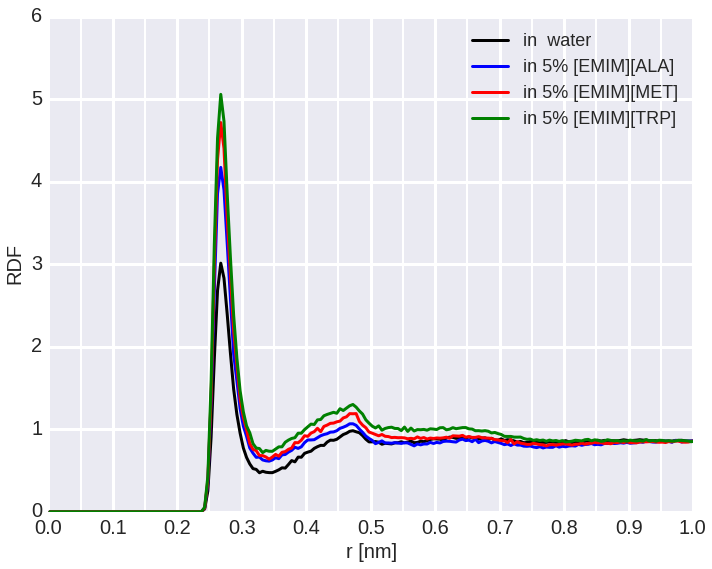

In [20]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
ax.plot(g_O_ser_O_wat[0], g_O_ser_O_wat[1], 'black', linewidth=linewidth, label='rdf_o_water')
ax.plot(g_O_ser_O_ala5[0], g_O_ser_O_ala5[1], 'blue', linewidth=linewidth, label='rdf_o_ala5')
ax.plot(g_O_ser_O_met5[0], g_O_ser_O_met5[1], 'red', linewidth=linewidth, label='rdf_o_ala5')
ax.plot(g_O_ser_O_trp5[0], g_O_ser_O_trp5[1], 'green', linewidth=linewidth, label='rdf_o_ala5')

# Legend
ax.legend(['in  water', 'in 5% [EMIM][ALA]', 'in 5% [EMIM][MET]', 'in 5% [EMIM][TRP]'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()

In [21]:
fig.savefig('serine.jpg')

In [23]:
data = {'name': ['water', '5% [EMIM][ALA]', '5% [EMIM][MET]', '5% [EMIM][TRP]'],
        'maxima': [g_O_ser_O_wat[2], g_O_ser_O_ala5[2], g_O_ser_O_met5[2], g_O_ser_O_trp5[2]],
        'minima': [g_O_ser_O_wat[3], g_O_ser_O_ala5[3], g_O_ser_O_met5[3], g_O_ser_O_trp5[3]],
        'coordination number': [g_O_ser_O_wat[4], g_O_ser_O_ala5[4], g_O_ser_O_met5[4], g_O_ser_O_trp5[4]]
       }
serine = pd.DataFrame(data)
serine

,coordination number,maxima,minima,name
0,3.948305,0.2775,0.3425,water
1,3.745925,0.2775,0.3475,5% [EMIM][ALA]
2,3.753525,0.2775,0.3475,5% [EMIM][MET]
3,3.719028,0.2775,0.3425,5% [EMIM][TRP]


In [24]:
serine.to_html('ser.html')

#RDF Carboxyl oxygen of the serine residue and acidic hydrogen (imidazole ring of emim)

##### Hydrogen atoms of EMIM

In [13]:
emim_H_ala5 = [atom.index for atom in topology_ala5.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]
emim_H_met5 = [atom.index for atom in topology_met5.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]
emim_H_trp5 = [atom.index for atom in topology_trp5.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]
emim_H_ala100 = [atom.index for atom in topology_ala100.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]
emim_H_met100 = [atom.index for atom in topology_met100.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]
emim_H_trp100 = [atom.index for atom in topology_trp100.atoms if ((atom.name == 'H5') and (atom.residue.name == 'EMI'))]

##### Compute RDFs

In [26]:
g = PairDistributionFunction(traj_ala5, ser_O_ala5, emim_H_ala5, upper_limit = 1.5)
g_O_ser_H_ala5 = g.rdf()
g = PairDistributionFunction(traj_ala100, ser_O_ala100, emim_H_ala100, upper_limit = 1.5)
g_O_ser_H_ala100 = g.rdf()

In [27]:
g = PairDistributionFunction(traj_met5, ser_O_met5, emim_H_met5, upper_limit = 1.5)
g_O_ser_H_met5 = g.rdf()
g = PairDistributionFunction(traj_met100, ser_O_met100, emim_H_met100, upper_limit = 1.5)
g_O_ser_H_met100 = g.rdf()

In [28]:
g = PairDistributionFunction(traj_trp5, ser_O_trp5, emim_H_trp5, upper_limit = 1.5)
g_O_ser_H_trp5 = g.rdf()
g = PairDistributionFunction(traj_trp100, ser_O_trp100, emim_H_trp100, upper_limit = 1.5)
g_O_ser_H_trp100 = g.rdf()

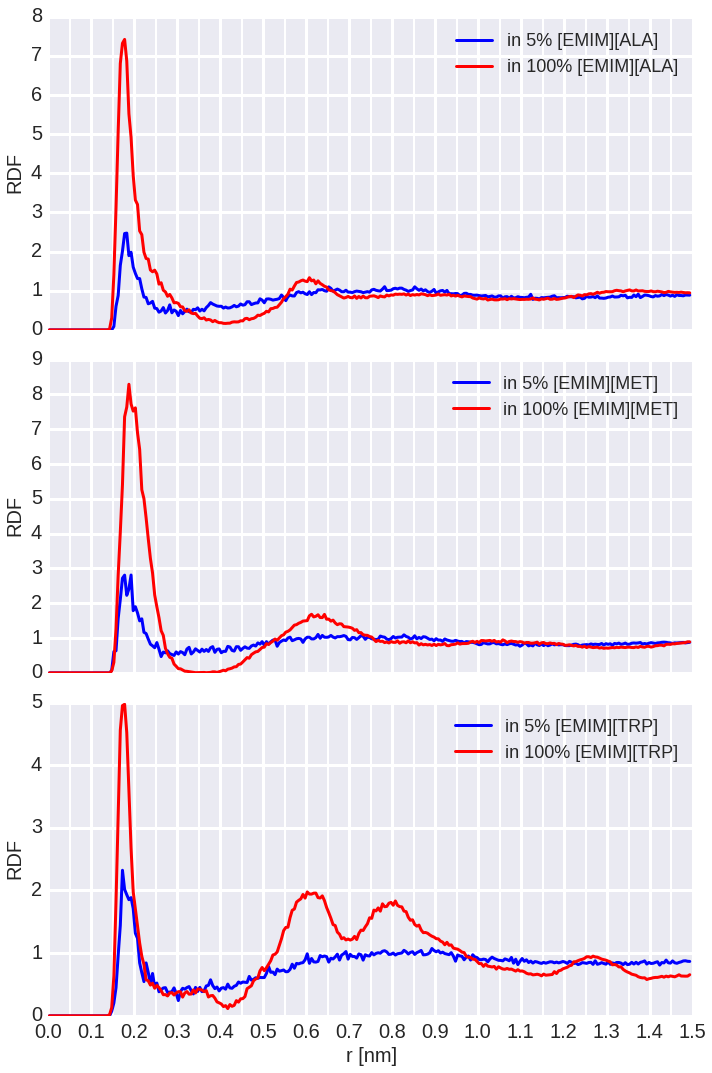

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,15))

#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(311)

for ax in axs:
    ax.tick_params(labelsize=20)
    ax.set_xlim([0., 1.5])
    linewidth = 3.0
    # Minor / major ticks definition
    minor_xticks = np.arange(0, 1.5, 0.05)
    ax.set_xticks(minor_xticks, minor=True)
    major_xticks = np.arange(0, 1.6, 0.1)
    ax.set_xticks(major_xticks)
    ax.grid(b=True, which='major', color='w', linewidth=3.0)
    ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
axs[0].plot(g_O_ser_H_ala5[0], g_O_ser_H_ala5[1], 'blue', linewidth=linewidth, label='rdf_ala5')
axs[0].plot(g_O_ser_H_ala100[0], g_O_ser_H_ala100[1], 'red', linewidth=linewidth, label='rdf_ala100')
axs[1].plot(g_O_ser_H_met5[0], g_O_ser_H_met5[1], 'blue', linewidth=linewidth, label='rdf_met5')
axs[1].plot(g_O_ser_H_met100[0], g_O_ser_H_met100[1], 'red', linewidth=linewidth, label='rdf_met100')
axs[2].plot(g_O_ser_H_trp5[0], g_O_ser_H_trp5[1], 'blue', linewidth=linewidth, label='rdf_trp5')
axs[2].plot(g_O_ser_H_trp100[0], g_O_ser_H_trp100[1], 'red', linewidth=linewidth, label='rdf_trp100')

# Legend
axs[0].legend(['in 5% [EMIM][ALA]', 'in 100% [EMIM][ALA]'], loc='best', prop={'size':18})
axs[1].legend(['in 5% [EMIM][MET]', 'in 100% [EMIM][MET]'], loc='best', prop={'size':18})
axs[2].legend(['in 5% [EMIM][TRP]', 'in 100% [EMIM][TRP]'], loc='best', prop={'size':18})
axs[2].set_xlabel('r [nm]', size=20)
for ax in axs:
    ax.set_ylabel('RDF', size=20)
    
fig.tight_layout()

In [30]:
fig.savefig('serine_emim.jpg')

In [32]:
data = {'name': ['5% [EMIM][ALA]', '100% [EMIM][ALA]', '5% [EMIM][MET]', '100% [EMIM][MET]', '5% [EMIM][TRP]', '100% [EMIM][TRP]', '100% [EMIM][TRP]'],
        'maxima': [g_O_ser_H_ala5[2], g_O_ser_H_ala100[2], g_O_ser_H_met5[2], g_O_ser_H_met100[2], g_O_ser_H_trp5[2], g_O_ser_H_trp100[2], 0.1825],
        'minima': [g_O_ser_H_ala5[3], g_O_ser_H_ala100[3], g_O_ser_H_met5[3], g_O_ser_H_met100[3], g_O_ser_H_trp5[3], g_O_ser_H_trp100[3], 0.4175],
        'coordination number': [g_O_ser_H_ala5[4], g_O_ser_H_ala100[4], g_O_ser_H_met5[4], g_O_ser_H_met100[4], g_O_ser_H_trp5[4], g_O_ser_H_trp100[4], 0.370413]
       }
serine_emim = pd.DataFrame(data)
serine_emim

,coordination number,maxima,minima,name
0,0.105189,0.1875,0.3125,5% [EMIM][ALA]
1,0.922358,0.1825,0.4175,100% [EMIM][ALA]
2,0.108689,0.1875,0.2975,5% [EMIM][MET]
3,0.773423,0.1975,0.3625,100% [EMIM][MET]
4,0.074193,0.1875,0.3025,5% [EMIM][TRP]
5,0.228177,0.1825,0.2875,100% [EMIM][TRP]
6,0.370413,0.1825,0.4175,100% [EMIM][TRP]


In [33]:
serine_emim.to_html('ser_emim.html')

#RDF Hydrogen atoms (methyl groups) of the leucine residue and acidic hydrogen (imidazole ring of emim) / oxygen atoms (ala/met/trp) / oxygen atoms (water)

##### Hydrogen atoms of the 2 LEUCINE residues

In [34]:
#for atom in topology_ala5.atoms:
#    if atom.residue.name == 'LEU':
#        if re.match(r'HD+', atom.name):
#            print(atom.name)

In [17]:
leu_H_ala5 = [atom.index for atom in topology_ala5.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]
leu_H_ala100 = [atom.index for atom in topology_ala100.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]
leu_H_met5 = [atom.index for atom in topology_met5.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]
leu_H_met100 = [atom.index for atom in topology_met100.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]
leu_H_trp5 = [atom.index for atom in topology_trp5.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]
leu_H_trp100 = [atom.index for atom in topology_trp100.atoms if ((re.match(r'HD+', atom.name)) and (atom.residue.name == 'LEU'))]

##### Oxygen atoms: ALA - MET - TRP

In [18]:
ala_O_ala5 = [atom.index for atom in topology_ala5.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'ALA'))]
ala_O_ala100 = [atom.index for atom in topology_ala100.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'ALA'))]
met_O_met5 = [atom.index for atom in topology_met5.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'MET'))]
met_O_met100 = [atom.index for atom in topology_met100.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'MET'))]
# Attention - one TRP residue in the protein --> adding another condition
trp_O_trp5 = [atom.index for atom in topology_trp5.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'TRP') and (atom.residue.index > 19))]
trp_O_trp100 = [atom.index for atom in topology_trp100.atoms if ((re.match(r'O+', atom.name)) and (atom.residue.name == 'TRP') and (atom.residue.index > 19))]

##### Compute RDFs

In [37]:
# Ala 5%
t = traj_ala5
c = leu_H_ala5
g = PairDistributionFunction(t, c, emim_H_ala5, upper_limit = 2.5)
g_H_leu_H_emim_ala5 = g.rdf()
g = PairDistributionFunction(t, c, ala_O_ala5, upper_limit = 2.5)
g_H_leu_O_ala_ala5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_ala5, upper_limit = 2.5)
g_H_leu_O_wat_ala5 = g.rdf()

In [38]:
# Ala 100%
t = traj_ala100
c = leu_H_ala100
g = PairDistributionFunction(t, c, emim_H_ala100, upper_limit = 2.5)
g_H_leu_H_emim_ala100 = g.rdf()
g = PairDistributionFunction(t, c, ala_O_ala100, upper_limit = 2.5)
g_H_leu_O_ala_ala100 = g.rdf()

In [39]:
# Met 5%
t = traj_met5
c = leu_H_met5
g = PairDistributionFunction(t, c, emim_H_met5, upper_limit = 2.5)
g_H_leu_H_emim_met5 = g.rdf()
g = PairDistributionFunction(t, c, met_O_met5, upper_limit = 2.5)
g_H_leu_O_met_met5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_met5, upper_limit = 2.5)
g_H_leu_O_wat_met5 = g.rdf()

In [40]:
# Met 100%
t = traj_met100
c = leu_H_met100
g = PairDistributionFunction(t, c, emim_H_met100, upper_limit = 2.5)
g_H_leu_H_emim_met100 = g.rdf()
g = PairDistributionFunction(t, c, met_O_met100, upper_limit = 2.5)
g_H_leu_O_met_met100 = g.rdf()

In [41]:
# Trp 5%
t = traj_trp5
c = leu_H_trp5
g = PairDistributionFunction(t, c, emim_H_trp5, upper_limit = 2.5)
g_H_leu_H_emim_trp5 = g.rdf()
g = PairDistributionFunction(t, c, trp_O_trp5, upper_limit = 2.5)
g_H_leu_O_trp_trp5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_trp5, upper_limit = 2.5)
g_H_leu_O_wat_trp5 = g.rdf()

In [42]:
# Trp 100%
t = traj_trp100
c = leu_H_trp100
g = PairDistributionFunction(t, c, emim_H_trp100, upper_limit = 2.5)
g_H_leu_H_emim_trp100 = g.rdf()
g = PairDistributionFunction(t, c, trp_O_trp100, upper_limit = 2.5)
g_H_leu_O_trp_trp100 = g.rdf()

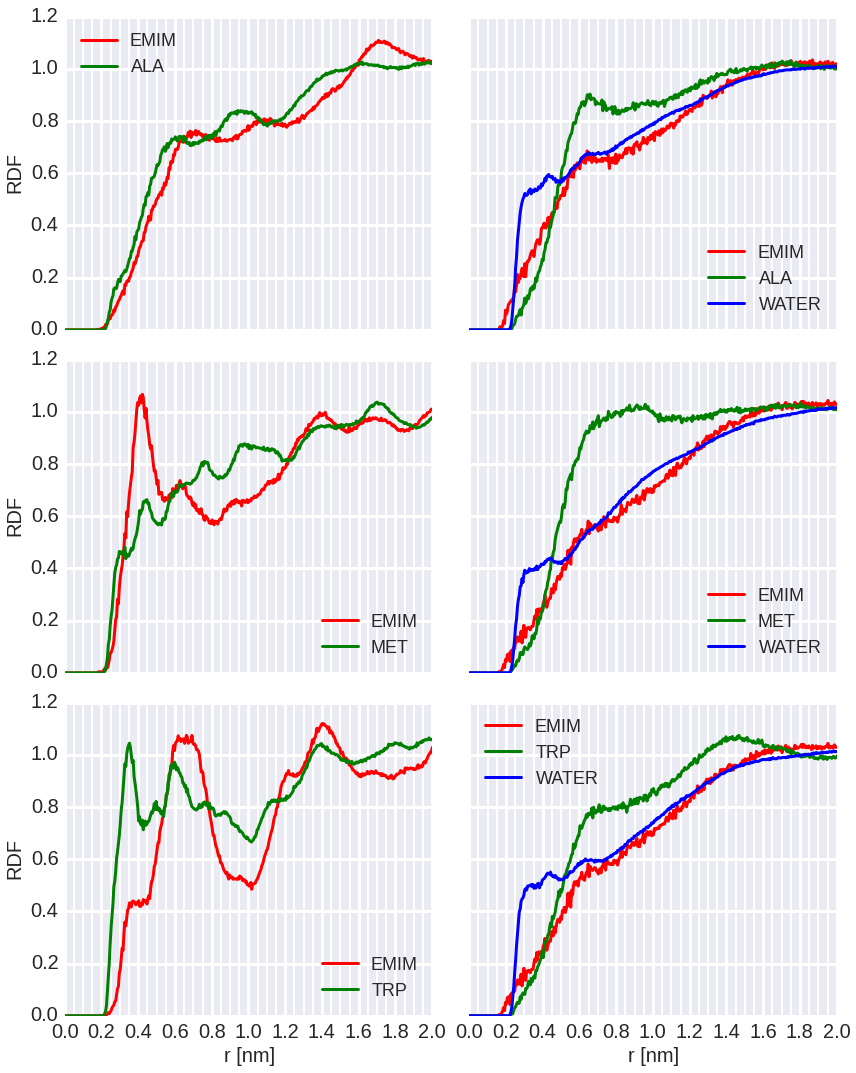

In [43]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12,15))

#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(311)

for ax1 in axs:
    for ax in ax1:
        ax.tick_params(labelsize=20)
        ax.set_xlim([0., 2.0])
        linewidth = 3.0
        # Minor / major ticks definition
        minor_xticks = np.arange(0, 2.0, 0.05)
        ax.set_xticks(minor_xticks, minor=True)
        major_xticks = np.arange(0, 2.1, 0.2)
        ax.set_xticks(major_xticks)
        ax.grid(b=True, which='major', color='w', linewidth=3.0)
        ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][ALA]
axs[0, 0].plot(g_H_leu_H_emim_ala100[0], g_H_leu_H_emim_ala100[1], 'red', linewidth=linewidth, label='rdf_ala100')
axs[0, 0].plot(g_H_leu_O_ala_ala100[0], g_H_leu_O_ala_ala100[1], 'green', linewidth=linewidth, label='rdf_ala100')
# 5% [EMIM][ALA]
axs[0, 1].plot(g_H_leu_H_emim_ala5[0], g_H_leu_H_emim_ala5[1], 'red', linewidth=linewidth, label='rdf_ala5')
axs[0, 1].plot(g_H_leu_O_ala_ala5[0], g_H_leu_O_ala_ala5[1], 'green', linewidth=linewidth, label='rdf_ala5')
axs[0, 1].plot(g_H_leu_O_wat_ala5[0], g_H_leu_O_wat_ala5[1], 'blue', linewidth=linewidth, label='rdf_ala5')
# 100% [EMIM][MET]
axs[1, 0].plot(g_H_leu_H_emim_met100[0], g_H_leu_H_emim_met100[1], 'red', linewidth=linewidth, label='rdf_met100')
axs[1, 0].plot(g_H_leu_O_met_met100[0], g_H_leu_O_met_met100[1], 'green', linewidth=linewidth, label='rdf_met100')
# 5% [EMIM][MET]
axs[1, 1].plot(g_H_leu_H_emim_met5[0], g_H_leu_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
axs[1, 1].plot(g_H_leu_O_met_met5[0], g_H_leu_O_met_met5[1], 'green', linewidth=linewidth, label='rdf_met5')
axs[1, 1].plot(g_H_leu_O_wat_met5[0], g_H_leu_O_wat_met5[1], 'blue', linewidth=linewidth, label='rdf_met5')
# 100% [EMIM][TRP]
axs[2, 0].plot(g_H_leu_H_emim_trp100[0], g_H_leu_H_emim_trp100[1], 'red', linewidth=linewidth, label='rdf_met100')
axs[2, 0].plot(g_H_leu_O_trp_trp100[0], g_H_leu_O_trp_trp100[1], 'green', linewidth=linewidth, label='rdf_met100')
# 5% [EMIM][TRP]
axs[2, 1].plot(g_H_leu_H_emim_trp5[0], g_H_leu_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
axs[2, 1].plot(g_H_leu_O_trp_trp5[0], g_H_leu_O_trp_trp5[1], 'green', linewidth=linewidth, label='rdf_met5')
axs[2, 1].plot(g_H_leu_O_wat_trp5[0], g_H_leu_O_wat_trp5[1], 'blue', linewidth=linewidth, label='rdf_met5')




# Legend
axs[0, 0].legend(['EMIM', 'ALA'], loc='best', prop={'size':18})
axs[0, 1].legend(['EMIM', 'ALA', 'WATER'], loc='best', prop={'size':18})
axs[1, 0].legend(['EMIM', 'MET'], loc='best', prop={'size':18})
axs[1, 1].legend(['EMIM', 'MET', 'WATER'], loc='best', prop={'size':18})
axs[2, 0].legend(['EMIM', 'TRP'], loc='best', prop={'size':18})
axs[2, 1].legend(['EMIM', 'TRP', 'WATER'], loc='best', prop={'size':18})
for ax in axs[:,0]:
    ax.set_ylabel('RDF', size=20)
for ax in axs[2,:]:
    ax.set_xlabel('r [nm]', size=20)
    
fig.tight_layout()

In [44]:
fig.savefig('leucine_one_plot.jpg')

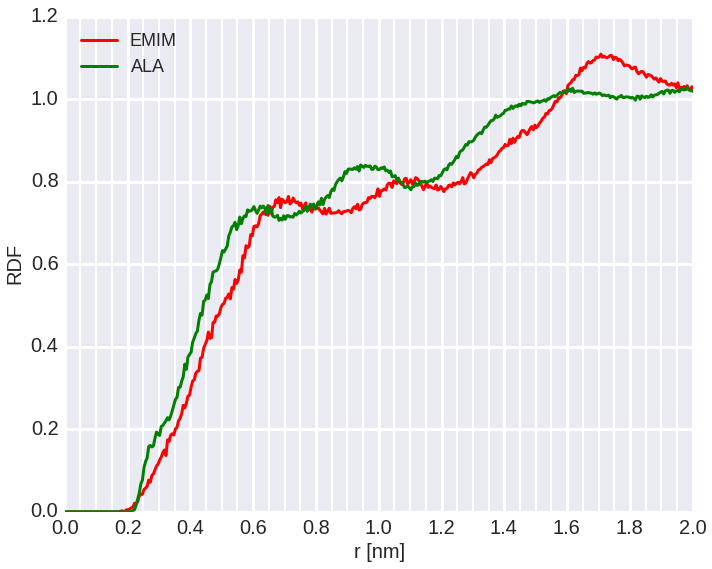

In [45]:
# 100% [EMIM][ALA]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][ALA]
ax.plot(g_H_leu_H_emim_ala100[0], g_H_leu_H_emim_ala100[1], 'red', linewidth=linewidth, label='rdf_ala100')
ax.plot(g_H_leu_O_ala_ala100[0], g_H_leu_O_ala_ala100[1], 'green', linewidth=linewidth, label='rdf_ala100')

# Legend
ax.legend(['EMIM', 'ALA'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_ala100.jpg')

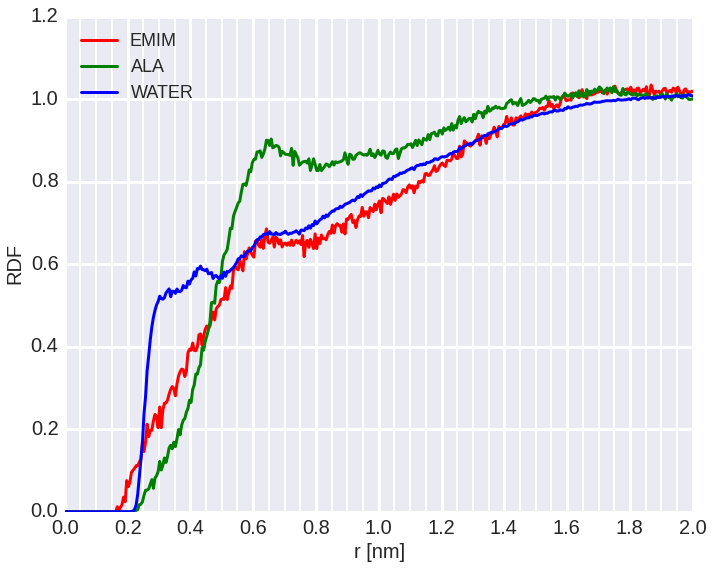

In [46]:
# 5% [EMIM][ALA]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][ALA]
ax.plot(g_H_leu_H_emim_ala5[0], g_H_leu_H_emim_ala5[1], 'red', linewidth=linewidth, label='rdf_ala5')
ax.plot(g_H_leu_O_ala_ala5[0], g_H_leu_O_ala_ala5[1], 'green', linewidth=linewidth, label='rdf_ala5')
ax.plot(g_H_leu_O_wat_ala5[0], g_H_leu_O_wat_ala5[1], 'blue', linewidth=linewidth, label='rdf_ala5')

# Legend
ax.legend(['EMIM', 'ALA','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_ala5.jpg')

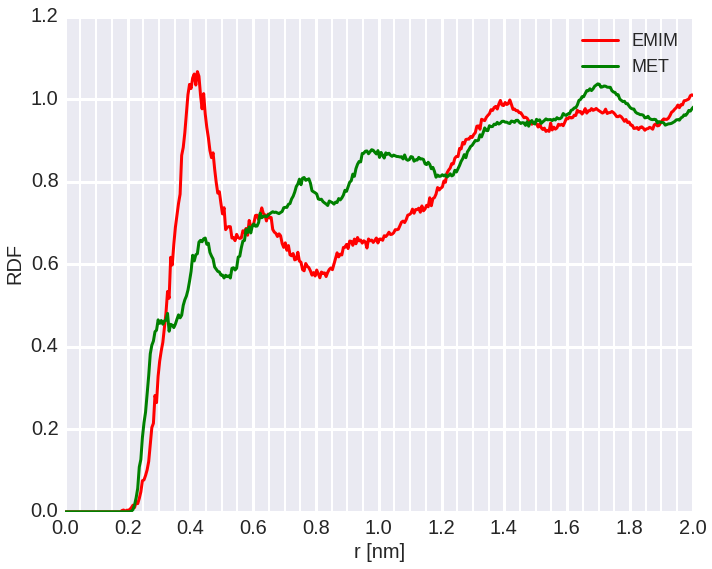

In [47]:
# 100% [EMIM][MET]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][MET]
ax.plot(g_H_leu_H_emim_met100[0], g_H_leu_H_emim_met100[1], 'red', linewidth=linewidth, label='rdf_ala100')
ax.plot(g_H_leu_O_met_met100[0], g_H_leu_O_met_met100[1], 'green', linewidth=linewidth, label='rdf_ala100')

# Legend
ax.legend(['EMIM', 'MET'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_met100.jpg')

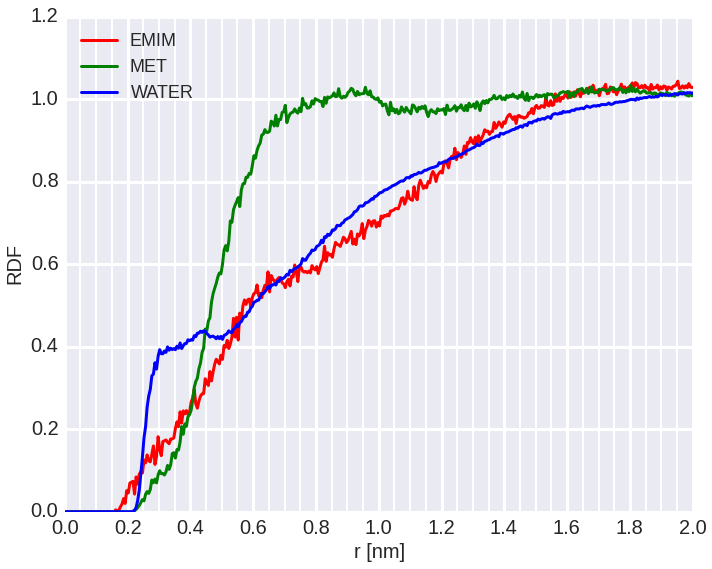

In [48]:
# 5% [EMIM][MET]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][MET]
ax.plot(g_H_leu_H_emim_met5[0], g_H_leu_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_leu_O_met_met5[0], g_H_leu_O_met_met5[1], 'green', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_leu_O_wat_met5[0], g_H_leu_O_wat_met5[1], 'blue', linewidth=linewidth, label='rdf_met5')

# Legend
ax.legend(['EMIM', 'MET','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_met5.jpg')

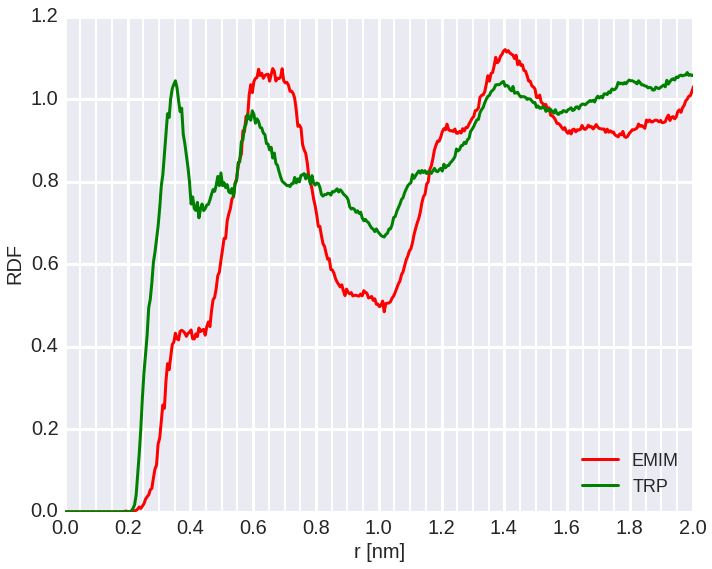

In [49]:
# 100% [EMIM][TRP]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][TRP]
ax.plot(g_H_leu_H_emim_trp100[0], g_H_leu_H_emim_trp100[1], 'red', linewidth=linewidth, label='rdf_met100')
ax.plot(g_H_leu_O_trp_trp100[0], g_H_leu_O_trp_trp100[1], 'green', linewidth=linewidth, label='rdf_met100')

# Legend
ax.legend(['EMIM', 'TRP'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_trp100.jpg')

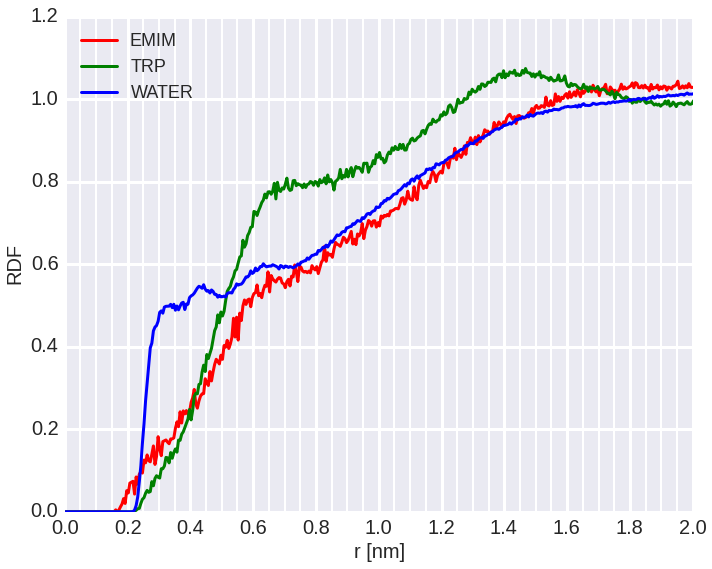

In [50]:
# 5% [EMIM][TRP]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 2.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 2., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 2.1, 0.2)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][TRP]
ax.plot(g_H_leu_H_emim_trp5[0], g_H_leu_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_leu_O_trp_trp5[0], g_H_leu_O_trp_trp5[1], 'green', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_leu_O_wat_trp5[0], g_H_leu_O_wat_trp5[1], 'blue', linewidth=linewidth, label='rdf_met5')

# Legend
ax.legend(['EMIM', 'TRP','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('leucine_trp5.jpg')

#RDF Hydrogen atoms (4 atoms on the azote atoms in position $\omega$) of the arginine residue and acidic hydrogen (imidazole ring of emim) / oxygen atoms (ala/met/trp) / oxygen atoms (water)

In [51]:
#for atom in topology_ala5.atoms:
#    if atom.residue.name == 'ARG':
#        if re.match(r'HH[1-2]+', atom.name):
#            print(atom.name)

In [14]:
arg_H_ala5 = [atom.index for atom in topology_ala5.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]
arg_H_ala100 = [atom.index for atom in topology_ala100.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]
arg_H_met5 = [atom.index for atom in topology_met5.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]
arg_H_met100 = [atom.index for atom in topology_met100.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]
arg_H_trp5 = [atom.index for atom in topology_trp5.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]
arg_H_trp100 = [atom.index for atom in topology_trp100.atoms if ((re.match(r'HH[1-2]+', atom.name)) and (atom.residue.name == 'ARG'))]

##### Compute RDFs

In [19]:
# Ala 5%
t = traj_ala5
c = arg_H_ala5
g = PairDistributionFunction(t, c, emim_H_ala5, upper_limit = 2.5)
g_H_arg_H_emim_ala5 = g.rdf()
g = PairDistributionFunction(t, c, ala_O_ala5, upper_limit = 2.5)
g_H_arg_O_ala_ala5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_ala5, upper_limit = 2.5)
g_H_arg_O_wat_ala5 = g.rdf()

In [20]:
# Ala 100%
t = traj_ala100
c = arg_H_ala100
g = PairDistributionFunction(t, c, emim_H_ala100, upper_limit = 2.5)
g_H_arg_H_emim_ala100 = g.rdf()
g = PairDistributionFunction(t, c, ala_O_ala100, upper_limit = 2.5)
g_H_arg_O_ala_ala100 = g.rdf()

In [21]:
# Met 5%
t = traj_met5
c = arg_H_met5
g = PairDistributionFunction(t, c, emim_H_met5, upper_limit = 2.5)
g_H_arg_H_emim_met5 = g.rdf()
g = PairDistributionFunction(t, c, met_O_met5, upper_limit = 2.5)
g_H_arg_O_met_met5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_met5, upper_limit = 2.5)
g_H_arg_O_wat_met5 = g.rdf()

In [22]:
# Met 100%
t = traj_met100
c = arg_H_met100
g = PairDistributionFunction(t, c, emim_H_met100, upper_limit = 2.5)
g_H_arg_H_emim_met100 = g.rdf()
g = PairDistributionFunction(t, c, met_O_met100, upper_limit = 2.5)
g_H_arg_O_met_met100 = g.rdf()

In [23]:
# Trp 5%
t = traj_trp5
c = arg_H_trp5
g = PairDistributionFunction(t, c, emim_H_trp5, upper_limit = 2.5)
g_H_arg_H_emim_trp5 = g.rdf()
g = PairDistributionFunction(t, c, trp_O_trp5, upper_limit = 2.5)
g_H_arg_O_trp_trp5 = g.rdf()
g = PairDistributionFunction(t, c, wat_O_trp5, upper_limit = 2.5)
g_H_arg_O_wat_trp5 = g.rdf()

In [24]:
# Trp 100%
t = traj_trp100
c = arg_H_trp100
g = PairDistributionFunction(t, c, emim_H_trp100, upper_limit = 2.5)
g_H_arg_H_emim_trp100 = g.rdf()
g = PairDistributionFunction(t, c, trp_O_trp100, upper_limit = 2.5)
g_H_arg_O_trp_trp100 = g.rdf()

##### Plots

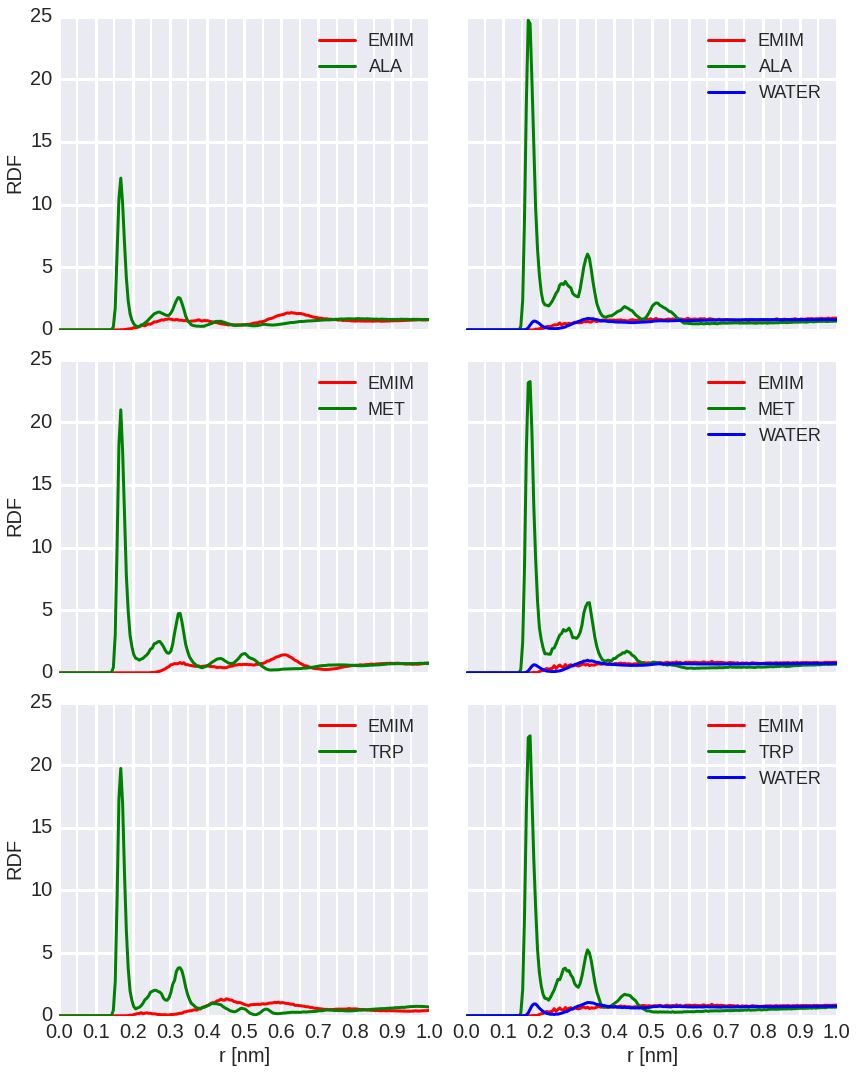

In [60]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12,15))

for ax1 in axs:
    for ax in ax1:
        ax.tick_params(labelsize=20)
        ax.set_xlim([0., 1.0])
        linewidth = 3.0
        # Minor / major ticks definition
        minor_xticks = np.arange(0, 1.0, 0.05)
        ax.set_xticks(minor_xticks, minor=True)
        major_xticks = np.arange(0, 1.1, 0.1)
        ax.set_xticks(major_xticks)
        ax.grid(b=True, which='major', color='w', linewidth=3.0)
        ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][ALA]
axs[0, 0].plot(g_H_arg_H_emim_ala100[0], g_H_arg_H_emim_ala100[1], 'red', linewidth=linewidth, label='rdf_ala100')
axs[0, 0].plot(g_H_arg_O_ala_ala100[0], g_H_arg_O_ala_ala100[1], 'green', linewidth=linewidth, label='rdf_ala100')
# 5% [EMIM][ALA]
axs[0, 1].plot(g_H_arg_H_emim_ala5[0], g_H_arg_H_emim_ala5[1], 'red', linewidth=linewidth, label='rdf_ala5')
axs[0, 1].plot(g_H_arg_O_ala_ala5[0], g_H_arg_O_ala_ala5[1], 'green', linewidth=linewidth, label='rdf_ala5')
axs[0, 1].plot(g_H_arg_O_wat_ala5[0], g_H_arg_O_wat_ala5[1], 'blue', linewidth=linewidth, label='rdf_ala5')
# 100% [EMIM][MET]
axs[1, 0].plot(g_H_arg_H_emim_met100[0], g_H_arg_H_emim_met100[1], 'red', linewidth=linewidth, label='rdf_met100')
axs[1, 0].plot(g_H_arg_O_met_met100[0], g_H_arg_O_met_met100[1], 'green', linewidth=linewidth, label='rdf_met100')
# 5% [EMIM][MET]
axs[1, 1].plot(g_H_arg_H_emim_met5[0], g_H_arg_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
axs[1, 1].plot(g_H_arg_O_met_met5[0], g_H_arg_O_met_met5[1], 'green', linewidth=linewidth, label='rdf_met5')
axs[1, 1].plot(g_H_arg_O_wat_met5[0], g_H_arg_O_wat_met5[1], 'blue', linewidth=linewidth, label='rdf_met5')
# 100% [EMIM][TRP]
axs[2, 0].plot(g_H_arg_H_emim_trp100[0], g_H_arg_H_emim_trp100[1], 'red', linewidth=linewidth, label='rdf_met100')
axs[2, 0].plot(g_H_arg_O_trp_trp100[0], g_H_arg_O_trp_trp100[1], 'green', linewidth=linewidth, label='rdf_met100')
# 5% [EMIM][TRP]
axs[2, 1].plot(g_H_arg_H_emim_trp5[0], g_H_arg_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
axs[2, 1].plot(g_H_arg_O_trp_trp5[0], g_H_arg_O_trp_trp5[1], 'green', linewidth=linewidth, label='rdf_met5')
axs[2, 1].plot(g_H_arg_O_wat_trp5[0], g_H_arg_O_wat_trp5[1], 'blue', linewidth=linewidth, label='rdf_met5')




# Legend
axs[0, 0].legend(['EMIM', 'ALA'], loc='best', prop={'size':18})
axs[0, 1].legend(['EMIM', 'ALA', 'WATER'], loc='best', prop={'size':18})
axs[1, 0].legend(['EMIM', 'MET'], loc='best', prop={'size':18})
axs[1, 1].legend(['EMIM', 'MET', 'WATER'], loc='best', prop={'size':18})
axs[2, 0].legend(['EMIM', 'TRP'], loc='best', prop={'size':18})
axs[2, 1].legend(['EMIM', 'TRP', 'WATER'], loc='best', prop={'size':18})
for ax in axs[:,0]:
    ax.set_ylabel('RDF', size=20)
for ax in axs[2,:]:
    ax.set_xlabel('r [nm]', size=20)
    
fig.tight_layout()
fig.savefig('arginine_one_plot.jpg')

In [61]:
data = {'name': ['5% [EMIM][ALA]', '100% [EMIM][ALA]', '5% [EMIM][MET]', '100% [EMIM][MET]', '5% [EMIM][TRP]', '100% [EMIM][TRP]'],
        'maxima': [g_H_arg_O_ala_ala5[2], g_H_arg_O_ala_ala100[2], g_H_arg_O_met_met5[2], g_H_arg_O_met_met100[2], g_H_arg_O_trp_trp5[2], g_H_arg_O_trp_trp100[2]],
        'minima': [g_H_arg_O_ala_ala5[3], g_H_arg_O_ala_ala100[3], g_H_arg_O_met_met5[3], g_H_arg_O_met_met100[3], g_H_arg_O_trp_trp5[3], g_H_arg_O_trp_trp100[3]],
        'coordination number': [g_H_arg_O_ala_ala5[4], g_H_arg_O_ala_ala100[4], g_H_arg_O_met_met5[4], g_H_arg_O_met_met100[4], g_H_arg_O_trp_trp5[4], g_H_arg_O_trp_trp100[4]]
       }
arginine_O_ala_met_trp = pd.DataFrame(data)
arginine_O_ala_met_trp

,coordination number,maxima,minima,name
0,0.669133,0.1775,0.2275,5% [EMIM][ALA]
1,0.709954,0.1725,0.2225,100% [EMIM][ALA]
2,0.562994,0.1775,0.2275,5% [EMIM][MET]
3,1.038471,0.1725,0.2225,100% [EMIM][MET]
4,0.494826,0.1775,0.2275,5% [EMIM][TRP]
5,0.762624,0.1725,0.2175,100% [EMIM][TRP]


In [69]:
arginine_O_ala_met_trp.to_html('arginine_O_ala_met_trp.html')

In [25]:
data = {'name': ['5% [EMIM][ALA]', '5% [EMIM][MET]', '5% [EMIM][TRP]'],
        'maxima': [g_H_arg_O_wat_ala5[2], g_H_arg_O_wat_met5[2], g_H_arg_O_wat_trp5[2]],
        'minima': [g_H_arg_O_wat_ala5[3], g_H_arg_O_wat_met5[3], g_H_arg_O_wat_trp5[3]],
        'coordination number': [g_H_arg_O_wat_ala5[4], g_H_arg_O_wat_met5[4], g_H_arg_O_wat_trp5[4]]
       }
arginine_O_wat = pd.DataFrame(data)
arginine_O_wat

,coordination number,maxima,minima,name
0,0.267598,0.1925,0.2425,5% [EMIM][ALA]
1,0.215378,0.1925,0.2375,5% [EMIM][MET]
2,0.297245,0.1925,0.2425,5% [EMIM][TRP]


In [26]:
arginine_O_wat.to_html('arginine_O_water.html')

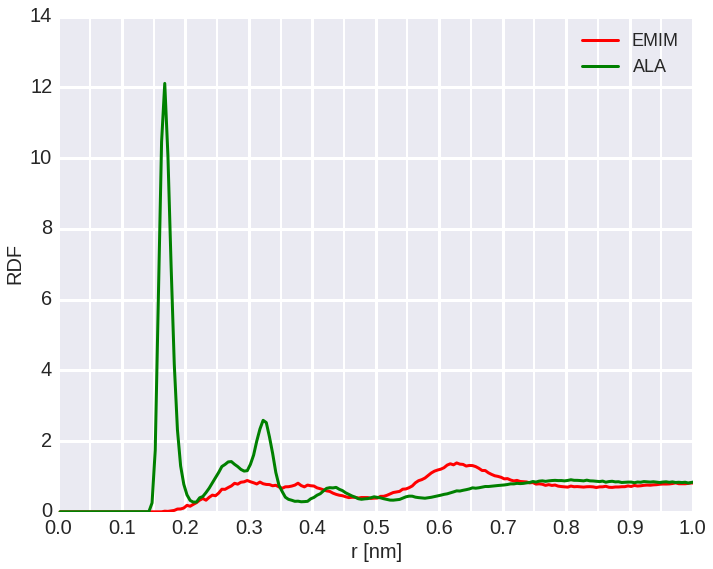

In [63]:
# 100% [EMIM][ALA]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][ALA]
ax.plot(g_H_arg_H_emim_ala100[0], g_H_arg_H_emim_ala100[1], 'red', linewidth=linewidth, label='rdf_ala100')
ax.plot(g_H_arg_O_ala_ala100[0], g_H_arg_O_ala_ala100[1], 'green', linewidth=linewidth, label='rdf_ala100')

# Legend
ax.legend(['EMIM', 'ALA'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_ala100.jpg')

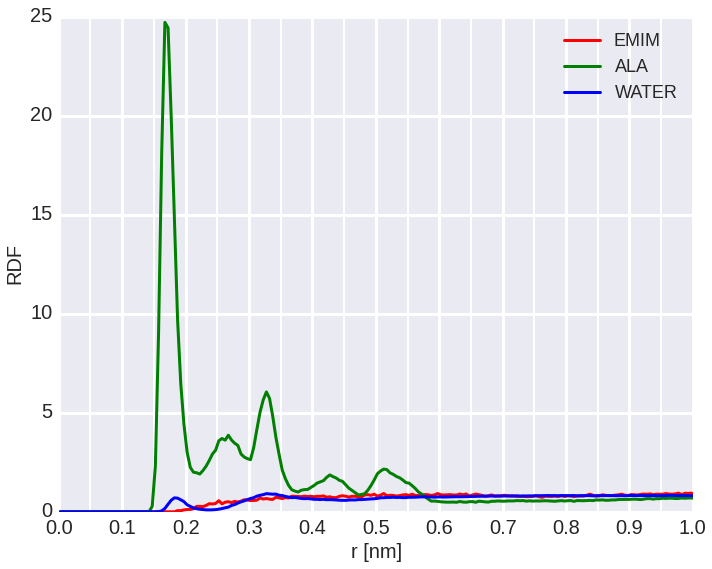

In [64]:
# 5% [EMIM][ALA]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][ALA]
ax.plot(g_H_arg_H_emim_ala5[0], g_H_arg_H_emim_ala5[1], 'red', linewidth=linewidth, label='rdf_ala5')
ax.plot(g_H_arg_O_ala_ala5[0], g_H_arg_O_ala_ala5[1], 'green', linewidth=linewidth, label='rdf_ala5')
ax.plot(g_H_arg_O_wat_ala5[0], g_H_arg_O_wat_ala5[1], 'blue', linewidth=linewidth, label='rdf_ala5')

# Legend
ax.legend(['EMIM', 'ALA','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_ala5.jpg')

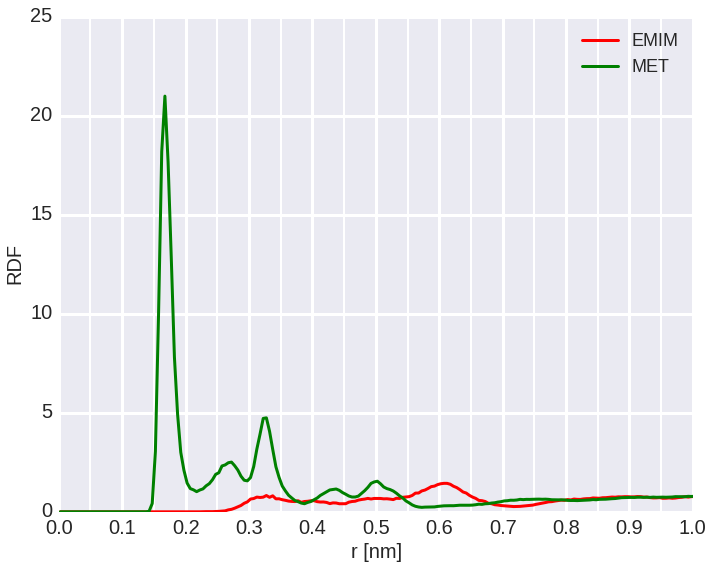

In [65]:
# 100% [EMIM][MET]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][MET]
ax.plot(g_H_arg_H_emim_met100[0], g_H_arg_H_emim_met100[1], 'red', linewidth=linewidth, label='rdf_ala100')
ax.plot(g_H_arg_O_met_met100[0], g_H_arg_O_met_met100[1], 'green', linewidth=linewidth, label='rdf_ala100')

# Legend
ax.legend(['EMIM', 'MET'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_met100.jpg')

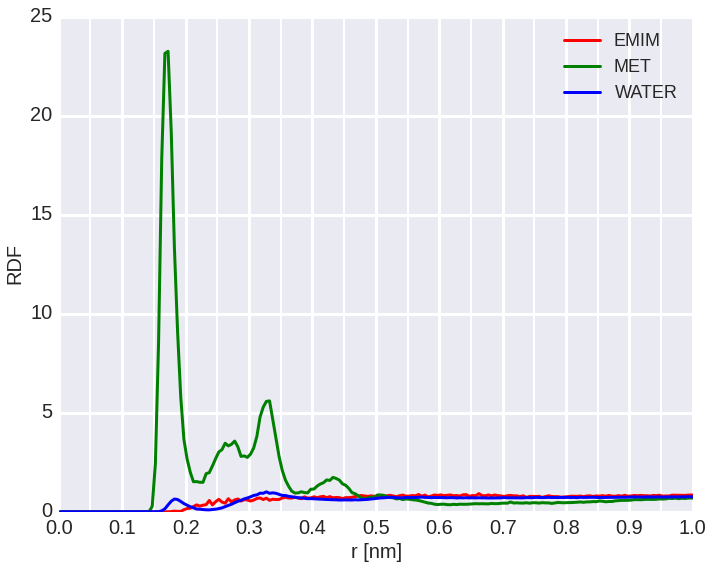

In [66]:
# 5% [EMIM][MET]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][MET]
ax.plot(g_H_arg_H_emim_met5[0], g_H_arg_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_arg_O_met_met5[0], g_H_arg_O_met_met5[1], 'green', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_arg_O_wat_met5[0], g_H_arg_O_wat_met5[1], 'blue', linewidth=linewidth, label='rdf_met5')

# Legend
ax.legend(['EMIM', 'MET','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_met5.jpg')

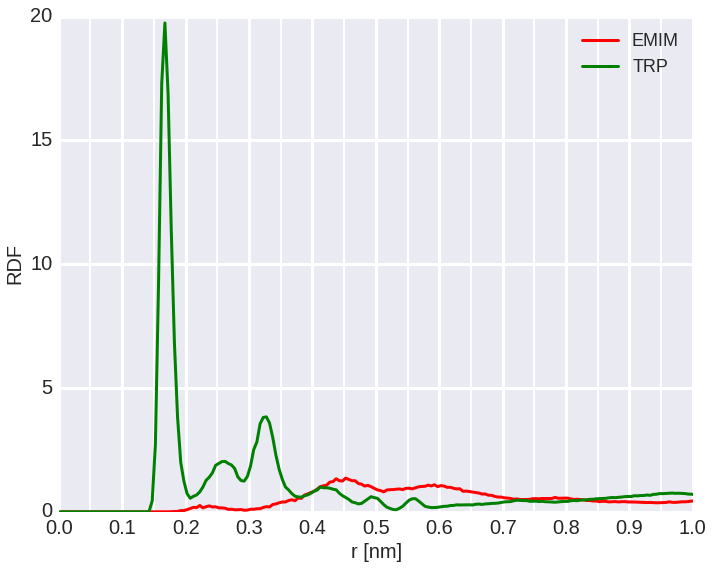

In [67]:
# 100% [EMIM][TRP]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 100% [EMIM][TRP]
ax.plot(g_H_arg_H_emim_trp100[0], g_H_arg_H_emim_trp100[1], 'red', linewidth=linewidth, label='rdf_met100')
ax.plot(g_H_arg_O_trp_trp100[0], g_H_arg_O_trp_trp100[1], 'green', linewidth=linewidth, label='rdf_met100')

# Legend
ax.legend(['EMIM', 'TRP'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_trp100.jpg')

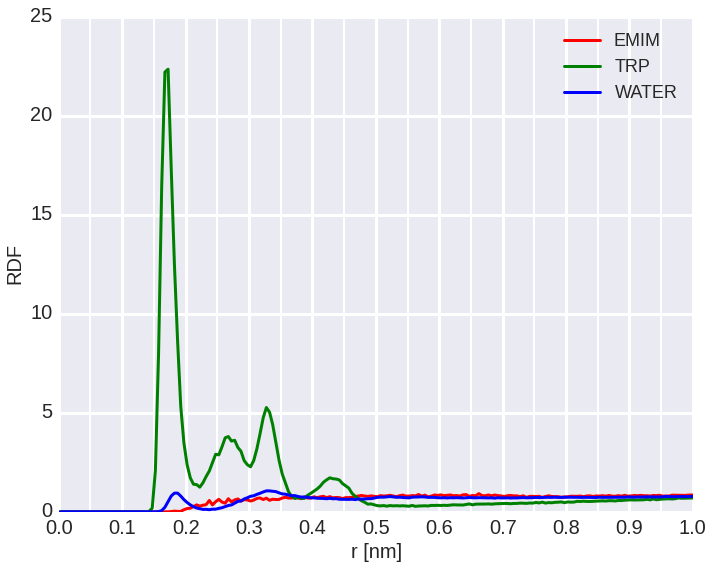

In [68]:
# 5% [EMIM][TRP]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.set_xlim([0., 1.])
linewidth = 3.0
# Minor / major ticks definition
minor_xticks = np.arange(0, 1., 0.05)
ax.set_xticks(minor_xticks, minor=True)
major_xticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.grid(b=True, which='major', color='w', linewidth=3.0)
ax.grid(b=True, which='minor', color='w', linewidth=2.0)

# DATA
# 5% [EMIM][TRP]
ax.plot(g_H_arg_H_emim_trp5[0], g_H_arg_H_emim_met5[1], 'red', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_arg_O_trp_trp5[0], g_H_arg_O_trp_trp5[1], 'green', linewidth=linewidth, label='rdf_met5')
ax.plot(g_H_arg_O_wat_trp5[0], g_H_arg_O_wat_trp5[1], 'blue', linewidth=linewidth, label='rdf_met5')

# Legend
ax.legend(['EMIM', 'TRP','WATER'], loc='best', prop={'size':18})
ax.set_xlabel('r [nm]', size=20)
ax.set_ylabel('RDF', size=20)

fig.tight_layout()
fig.savefig('arginine_trp5.jpg')